In [ ]:
# Mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Importing libraries**

In [ ]:
# Import the required libraries
import zipfile
import os
import random
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Conv2DTranspose, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jan  6 16:13:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              25W /  70W |    103MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## **Loading images and building datasets**

In [ ]:
# Define the paths to the training and test datasets
images_folder = '/content/drive/MyDrive/Retina_Vascular_Segmentation/Data/Image_Set/'
masks_folder = '/content/drive/MyDrive/Retina_Vascular_Segmentation/Data/Mask_Set/'

# Get the list of file names in each folder
image_files = os.listdir(images_folder)
mask_files = os.listdir(masks_folder)

# Sort the files to ensure they are in the same order
image_files.sort()
mask_files.sort()

# Initialize empty lists to store the images and masks
image_set = []
mask_set = []

# Load images and masks
for img_file, mask_file in zip(image_files, mask_files):
    img_path = os.path.join(images_folder, img_file)
    mask_path = os.path.join(masks_folder, mask_file)

    img = imread(img_path)
    mask = imread(mask_path)

    image_set.append(img)
    mask_set.append(mask)

# Convert the lists to numpy arrays
image_set = np.array(image_set)
mask_set = np.array(mask_set)

# Print the shapes of the resulting arrays
print("image_set shape:", image_set.shape)
print("mask_set shape:", mask_set.shape)

image_set shape: (100, 512, 512, 3)
mask_set shape: (100, 512, 512)


##**Splitting the images and masks to training and test sets**

In [ ]:
# Flatten the mask_set to (N, H*W) to use with train_test_split
mask_set_flat = mask_set.reshape((mask_set.shape[0], -1))

# Split the datasets into training and testing sets
image_train, image_test, mask_train_flat, mask_test_flat = train_test_split(
    image_set, mask_set_flat, test_size=0.2, random_state=42)

# Reshape the flattened mask back to its original shape
mask_train = mask_train_flat.reshape((mask_train_flat.shape[0], mask_set.shape[1], mask_set.shape[2]))
mask_test = mask_test_flat.reshape((mask_test_flat.shape[0], mask_set.shape[1], mask_set.shape[2]))

# Print the shapes of the resulting datasets
print("Training set shapes:")
print("Image set:", image_train.shape)
print("Mask set:", mask_train.shape)

print("\nTesting set shapes:")
print("Image set:", image_test.shape)
print("Mask set:", mask_test.shape)

X_train = image_train
Y_train = mask_train

X_test = image_test
Y_test = mask_test


Training set shapes:
Image set: (80, 512, 512, 3)
Mask set: (80, 512, 512)

Testing set shapes:
Image set: (20, 512, 512, 3)
Mask set: (20, 512, 512)


In [ ]:
# Make a copy of all the datasets
X_train_orig = X_train
Y_train_orig = Y_train
X_test_orig = X_test
Y_test_orig = Y_test

## **Plotting a random image and its mask**

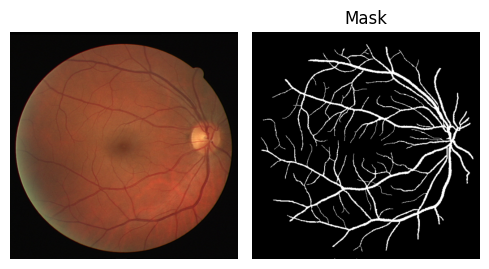

In [ ]:
# Randomly choose an index from the training set
random_index = np.random.randint(0, len(X_train))

# Get the randomly chosen image and its corresponding mask
random_image = X_train[random_index]
random_mask = Y_train[random_index]

# Set the size of the plot
plt.figure(figsize=(5, 5))

# Plot the image
plt.subplot(1, 2, 1)
plt.imshow(random_image)
plt.axis('off')

# Plot the mask
plt.subplot(1, 2, 2)
plt.imshow(random_mask, cmap='gray')
plt.title("Mask")
plt.axis('off')

plt.tight_layout()
plt.show()


## **Image pre-processing**

### **Coverting RGB to gray scale**

In [ ]:
def rgb_to_gray_weighted(images):
    """
    Convert a dataset of RGB images to grayscale using weighted average.

    Args:
        images (numpy.ndarray): Input image dataset of shape (num_images, height, width, channels).

    Returns:
        numpy.ndarray: Grayscale image dataset of shape (num_images, height, width, 1).
    """
    # Apply weighted average to each image in the dataset
    #gray_images = np.dot(images[...,:3], [0.299, 0.587, 0.114]).reshape(images.shape[:-1] + (1,))
    gray_images = np.dot(images[...,:3], [0.0, 0.7, 0.3]).reshape(images.shape[:-1] + (1,))

    return gray_images

### **Histogram equalization**

In [ ]:
def apply_histogram_equalization(image_set):
    """
    Apply histogram equalization to each image in the dataset.

    Args:
        image_set (numpy.ndarray): Input image dataset of shape (num_images, height, width, channels).

    Returns:
        numpy.ndarray: Image dataset with equalized histograms.
    """
    # Create an empty array to store the images with equalized histograms
    equalized_images = np.empty(image_set.shape)

    # Iterate over each image in the dataset
    for i in range(image_set.shape[0]):

        # Apply histogram equalization to each channel separately
        equalized_image = np.empty_like(image_set[i])
        for c in range(image_set.shape[3]):
            equalized_image[..., c] = cv2.equalizeHist(image_set[i, ..., c].astype(np.uint8))

        # Store the image with equalized histogram in the output array
        equalized_images[i] = equalized_image

    return equalized_images


### **Applying CLAHE**

In [ ]:
def apply_contrast_enhancement(image_set):
    """
    Apply contrast enhancement (CLAHE) to each image in the dataset.

    Args:
        image_set (numpy.ndarray): Input image dataset of shape (num_images, height, width, channels).

    Returns:
        numpy.ndarray: Image dataset with enhanced contrast.
    """
    # Create an empty array to store the images with enhanced contrast
    enhanced_images = np.empty(image_set.shape)

    # Iterate over each image in the dataset
    for i in range(image_set.shape[0]):
        # Apply contrast enhancement (CLAHE) to each channel separately
        enhanced_image = np.empty_like(image_set[i])
        for c in range(image_set.shape[3]):
            # Apply CLAHE to the channel
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            #clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(32, 32))
            enhanced_image[..., c] = clahe.apply(image_set[i, ..., c].astype(np.uint8))

        # Store the image with enhanced contrast in the output array
        enhanced_images[i] = enhanced_image

    return enhanced_images


### **Grid-based Contrast Enhancement**

In [ ]:
def grid_based_enhance_contrast(image_set, grid_size=(4, 4), method='clahe', clip_limit=2.0):
    """
    Enhance contrast in a dataset of grayscale images by applying CLAHE or histogram equalization to sub-images.

    Args:
        image_set (numpy.ndarray): Input image dataset of shape (num_images, height, width, channels).
        grid_size (tuple): Number of rows and columns for the grid.
        method (str): 'clahe' for CLAHE, 'hist' for histogram equalization.
        clip_limit (float): Threshold for contrast limiting in CLAHE.

    Returns:
        numpy.ndarray: Enhanced and normalized grayscale image dataset.
    """
    # Check if the input dataset has the correct shape
    if len(image_set.shape) != 4 or image_set.shape[-1] != 1:
        raise ValueError("Input dataset must be a grayscale image dataset with shape (num_images, height, width, 1).")

    # Convert the images to 8-bit unsigned integer if not already
    if image_set.dtype != np.uint8:
        image_set = np.clip(image_set, 0, 255).astype(np.uint8)

    # Calculate the dimensions of each sub-image
    num_images, rows, cols, _ = image_set.shape
    sub_image_height = rows // grid_size[0]
    sub_image_width = cols // grid_size[1]

    # Initialize the enhanced image dataset
    enhanced_images = np.zeros_like(image_set, dtype=np.float32)

    # Apply contrast enhancement to each image in the dataset
    for k in range(num_images):
        for i in range(grid_size[0]):
            for j in range(grid_size[1]):
                # Define the coordinates for the sub-image
                start_row = i * sub_image_height
                end_row = (i + 1) * sub_image_height
                start_col = j * sub_image_width
                end_col = (j + 1) * sub_image_width

                # Extract the sub-image
                sub_image = image_set[k, start_row:end_row, start_col:end_col, :]

                # Apply contrast enhancement to the sub-image
                if method == 'clahe':
                    # Apply CLAHE to the sub-image
                    clahe = cv2.createCLAHE(clipLimit=clip_limit)
                    # Remove singleton dimension
                    enhanced_sub_image = clahe.apply(sub_image.squeeze())
                elif method == 'hist':
                    # Apply histogram equalization to the sub-image
                    enhanced_sub_image = cv2.equalizeHist(sub_image.squeeze())
                else:
                    raise ValueError("Invalid method. Use 'clahe' or 'hist'.")

                # Ensure enhanced_sub_image has the same shape as the original
                enhanced_sub_image = np.expand_dims(enhanced_sub_image, axis=-1)

                # Update the enhanced image dataset with the processed sub-image
                enhanced_images[k, start_row:end_row, start_col:end_col, :] = enhanced_sub_image

    return enhanced_images


### **Gamma correction**

In [ ]:
def apply_gamma_correction(image_set, gamma=1.0):
    """
    Apply Gamma correction to each image in the dataset.

    Args:
        image_set (numpy.ndarray): Input image dataset of shape (num_images, height, width, channels).
        gamma (float): Gamma value for correction (default is 1.0, which means no correction).

    Returns:
        numpy.ndarray: Image dataset with Gamma correction applied.
    """
    # Create an empty array to store the images with Gamma correction applied
    corrected_images = np.empty(image_set.shape)

    # Iterate over each image in the dataset
    for i in range(image_set.shape[0]):
        # Apply Gamma correction to each channel separately
        corrected_image = np.power(image_set[i], gamma)

        # Normalize the values to be in the range [0, 255]
        corrected_image = (corrected_image / np.max(corrected_image)) * 255

        # Store the image with Gamma correction in the output array
        corrected_images[i] = corrected_image

    return corrected_images


### **Unsharp masking**

In [ ]:
def apply_unsharp_masking(image_set, alpha=1.5):
    """
    Apply Unsharp Masking to each image in the dataset.

    Args:
        image_set (numpy.ndarray): Input image dataset of shape (num_images, height, width, channels).
        alpha (float): Enhancement factor (default is 1.5).

    Returns:
        numpy.ndarray: Image dataset with Unsharp Masking applied.
    """
    # Create an empty array to store the images with Unsharp Masking applied
    sharpened_images = np.empty(image_set.shape)

    # Define a high-pass filter (Laplacian kernel)
    laplacian_kernel = np.array([[0, 1, 0],
                                 [1, -4, 1],
                                 [0, 1, 0]])

    # Iterate over each image in the dataset
    for i in range(image_set.shape[0]):
        # Apply the high-pass filter to extract edges and construct the mask
        edges = cv2.filter2D(image_set[i], -1, laplacian_kernel)

        # Multiply the mask with the enhancement factor
        mask = alpha * edges

        # Blur the original image
        blurred_image = cv2.GaussianBlur(image_set[i], (5, 5), 1.5)

        # Add the result of the previous step to the blurred image
        sharpened_image = cv2.add(blurred_image, mask)

        # Store the sharpened image in the output array
        sharpened_images[i] = sharpened_image

    return sharpened_images


## **Image augmentation**

In [ ]:
def custom_augmentation(image, mask):
    """
    Apply custom data augmentation to a gray image and its corresponding mask.

    Args:
        image (numpy.ndarray): Input gray image.
        mask (numpy.ndarray): Corresponding mask.

    Returns:
        numpy.ndarray: Augmented gray image.
        numpy.ndarray: Augmented mask.
    """
    # Randomly select an augmentation type
    augmentation_type = np.random.choice(['rotate', 'flip_vertical', 'flip_horizontal', 'zoom_in', 'shear', 'blur'])

    if augmentation_type == 'rotate':
        # Randomly rotate the image and mask
        angle = np.random.randint(1, 360)
        rows, cols = image.shape
        M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
        augmented_image = cv2.warpAffine(image, M, (cols, rows))
        augmented_mask = cv2.warpAffine(mask, M, (cols, rows))

    elif augmentation_type == 'flip_vertical':
        # Flip the image and mask vertically
        augmented_image = cv2.flip(image, 0)
        augmented_mask = cv2.flip(mask, 0)

    elif augmentation_type == 'flip_horizontal':
        # Flip the image and mask horizontally
        augmented_image = cv2.flip(image, 1)
        augmented_mask = cv2.flip(mask, 1)

    elif augmentation_type == 'zoom_in':
        # Randomly zoom in the image and mask
        scale = np.random.uniform(1.1, 1.5)
        augmented_image = cv2.resize(image, None, fx=scale, fy=scale)
        augmented_mask = cv2.resize(mask, None, fx=scale, fy=scale)

        rows, cols = augmented_image.shape
        crop_x = int((cols - image.shape[1]) / 2)
        crop_y = int((rows - image.shape[0]) / 2)
        augmented_image = augmented_image[crop_y:crop_y+image.shape[0], crop_x:crop_x+image.shape[1]]
        augmented_mask = augmented_mask[crop_y:crop_y+image.shape[0], crop_x:crop_x+image.shape[1]]

    elif augmentation_type == 'shear':
        # Apply shear transformation to the image and mask
        shear_range = np.random.uniform(0.1, 0.3)
        shear_matrix = np.array([[1, shear_range, 0], [0, 1, 0]], dtype=np.float32)
        augmented_image = cv2.warpAffine(image, shear_matrix, (image.shape[1], image.shape[0]))
        augmented_mask = cv2.warpAffine(mask, shear_matrix, (mask.shape[1], mask.shape[0]))

    elif augmentation_type == 'blur':
        # Apply Gaussian blur to the image
        blur_amount = np.random.uniform(1, 5)
        augmented_image = cv2.GaussianBlur(image, (int(blur_amount)*2 + 1, int(blur_amount)*2 + 1), 0)
        augmented_mask = mask

    return augmented_image, augmented_mask

def apply_custom_augmentation(image_set, mask_set, augmentation_factor=2):
    """
    Apply custom data augmentation to a dataset of gray images and their corresponding masks.

    Args:
        image_set (numpy.ndarray): Input gray image dataset.
        mask_set (numpy.ndarray): Corresponding mask dataset.
        augmentation_factor (int): Factor by which to increase the dataset size (default is 2).

    Returns:
        numpy.ndarray: Enlarged gray image dataset.
        numpy.ndarray: Enlarged mask dataset.
    """
    augmented_images = []
    augmented_masks = []

    for i in range(image_set.shape[0]):
        # Remove the singleton dimension
        img = image_set[i].squeeze()
        msk = mask_set[i]

        aug_images = []
        aug_masks = []
        for _ in range(augmentation_factor):
            aug_img, aug_msk = custom_augmentation(img, msk)
            aug_images.append(aug_img)
            aug_masks.append(aug_msk)

        augmented_images.extend(aug_images)
        augmented_masks.extend(aug_masks)

    # Add singleton dimension back
    augmented_images = np.array(augmented_images)[:, :, :, np.newaxis]
    augmented_masks = np.array(augmented_masks)

    enlarged_image_set = np.concatenate((image_set, augmented_images), axis=0)
    enlarged_mask_set = np.concatenate((mask_set, augmented_masks), axis=0)

    return enlarged_image_set, enlarged_mask_set


## **Generating patches**

### **Non-overlapping patches**

In [ ]:
def generate_non_overlapping_patches(image_set, mask_set, patch_size):
    """
    Generate non-overlapping patches from the images and their masks.

    Args:
        image_set (numpy.ndarray): Input image dataset of shape (num_images, height, width, channels).
        mask_set (numpy.ndarray): Corresponding mask dataset of shape (num_images, height, width).
        patch_size (int): Size of the patches (assumes square patches).

    Returns:
        numpy.ndarray: Dataset of patches extracted from the images.
        numpy.ndarray: Dataset of patches extracted from the masks.
    """
    # Calculate the number of patches that can fit in each dimension
    num_patches_height = image_set.shape[1] // patch_size
    num_patches_width = image_set.shape[2] // patch_size

    # Initialize lists to store patches
    patches_images = []
    patches_masks = []

    # Extract non-overlapping patches from images and masks
    for i in range(image_set.shape[0]):
        for h in range(num_patches_height):
            for w in range(num_patches_width):
                # Define the coordinates for the patch
                start_h = h * patch_size
                end_h = (h + 1) * patch_size
                start_w = w * patch_size
                end_w = (w + 1) * patch_size

                # Extract patches from the image and mask
                patch_image = image_set[i, start_h:end_h, start_w:end_w, :]
                patch_mask = mask_set[i, start_h:end_h, start_w:end_w]

                # Append the patches to the lists
                patches_images.append(patch_image)
                patches_masks.append(patch_mask)

    # Convert lists to numpy arrays
    patches_images = np.array(patches_images)
    patches_masks = np.array(patches_masks)

    return patches_images, patches_masks


### **Overlapping patches**

In [ ]:
def generate_overlapping_patches(image_set, mask_set, patch_size, stride):
    """
    Generate overlapping patches from the images and their masks.

    Args:
        image_set (numpy.ndarray): Input image dataset of shape (num_images, height, width, channels).
        mask_set (numpy.ndarray): Corresponding mask dataset of shape (num_images, height, width, channels).
        patch_size (int): Size of the patches (assumes square patches).
        stride (int): Stride for patch extraction.

    Returns:
        numpy.ndarray: Dataset of patches extracted from the images.
        numpy.ndarray: Dataset of patches extracted from the masks.
    """
    # Initialize lists to store patches
    patches_images = []
    patches_masks = []

    # Extract overlapping patches from images and masks
    for i in range(image_set.shape[0]):
        for h in range(0, image_set.shape[1] - patch_size + 1, stride):
            for w in range(0, image_set.shape[2] - patch_size + 1, stride):
                # Define the coordinates for the patch
                start_h = h
                end_h = h + patch_size
                start_w = w
                end_w = w + patch_size

                # Extract patches from the image and mask
                patch_image = image_set[i, start_h:end_h, start_w:end_w, :]
                patch_mask = mask_set[i, start_h:end_h, start_w:end_w, :]

                # Append the patches to the lists
                patches_images.append(patch_image)
                patches_masks.append(patch_mask)

    # Convert lists to numpy arrays
    patches_images = np.array(patches_images)
    patches_masks = np.array(patches_masks)

    return patches_images, patches_masks


## **Applying the image pre-processing steps**

### **Converting the color images into gray images**

In [ ]:
X_train_gray = rgb_to_gray_weighted(X_train)
X_test_gray = rgb_to_gray_weighted(X_test)

### **Plotting random gray image from training set**

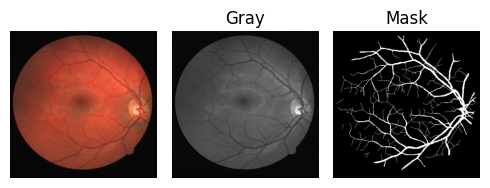

In [ ]:
# Randomly choose an index from the training set
random_index = np.random.randint(0, len(X_train_gray))

# Get the randomly chosen image and its corresponding mask
random_image = X_train[random_index]
random_image_gray = X_train_gray[random_index]
random_mask = Y_train[random_index]

plt.figure(figsize=(5, 7.5))

# Plot the color image
plt.subplot(1, 3, 1)
plt.imshow(random_image)
plt.axis('off')

# Plot the gray image
plt.subplot(1, 3, 2)
plt.imshow(random_image_gray, cmap='gray')
plt.title("Gray")
plt.axis('off')

# Plot the mask
plt.subplot(1, 3, 3)
plt.imshow(random_mask, cmap='gray')
plt.title("Mask")
plt.axis('off')

plt.tight_layout()
plt.show()


### **Exploring the image enhancement effect on 5 random images**

In [ ]:
X_train = X_train_gray
X_test = X_test_gray

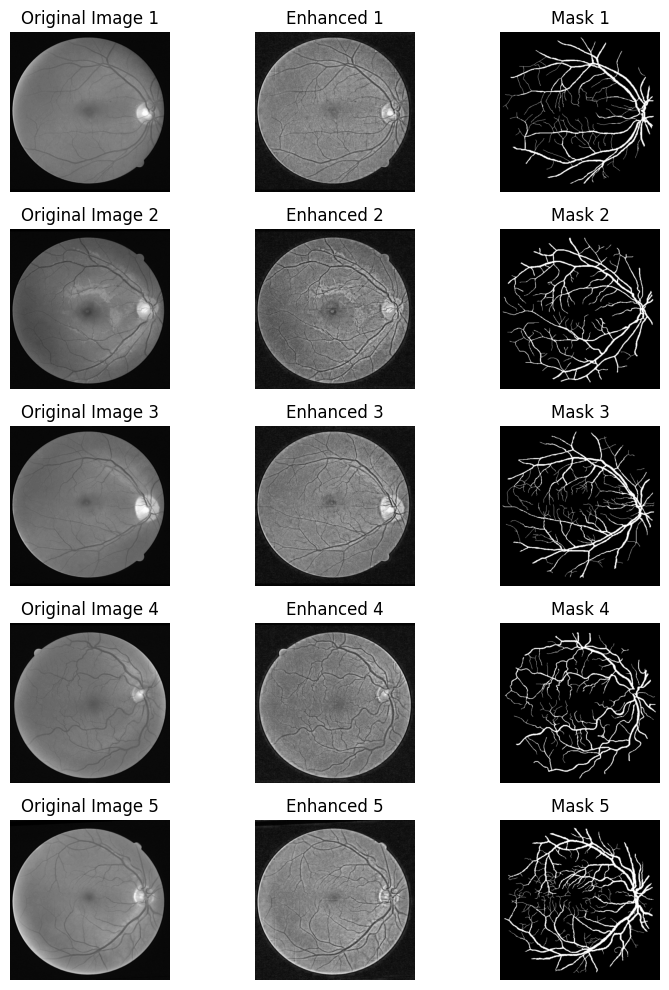

In [ ]:
# Step 1: Randomly select 5 images
random.seed(99)
selected_indices = random.sample(range(len(X_train)), 5)
selected_images = X_train[selected_indices]
selected_masks = Y_train[selected_indices]

# Step 2: Apply image processing techniques
#enhanced_images = apply_histogram_equalization(enhanced_images)
enhanced_images = selected_images
#enhanced_images = apply_contrast_enhancement(enhanced_images)
#enhanced_images = apply_contrast_enhancement(enhanced_images)

# Enhance contrast in the dataset using histogram equalization
enhanced_images = grid_based_enhance_contrast(enhanced_images, grid_size=(8, 8), method='clahe')
enhanced_images = apply_gamma_correction(enhanced_images, gamma = 0.9)


# Step 3: Create a grid of plots
fig, axes = plt.subplots(5, 3, figsize=(8, 10))

for i in range(5):
    # Original Image
    axes[i, 0].imshow(selected_images[i], cmap = 'gray')
    axes[i, 0].set_title(f'Original Image {i+1}')
    axes[i, 0].axis('off')

    # Enhanced Image
    axes[i, 1].imshow(enhanced_images[i].astype(np.uint8), cmap = 'gray')
    axes[i, 1].set_title(f'Enhanced {i+1}')
    axes[i, 1].axis('off')

    # Corresponding Mask
    axes[i, 2].imshow(selected_masks[i, :, :], cmap='gray')
    axes[i, 2].set_title(f'Mask {i+1}')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()


### **Applying the image enhancement on the training dataset**

In [ ]:
def image_preprocessor(image_dataset):
    """
    Apply multiple functions consecutively on a dataset of RGB images.

    Args:
        image_dataset (numpy.ndarray): Input image dataset of shape (num_images, height, width, channels).
        func1 (callable): First enhancement function.
        func2 (callable): Second enhancement function.
        func3 (callable): Third enhancement function.

    Returns:
        numpy.ndarray: Image dataset with consecutive enhancements applied.
    """
    enhanced_images = image_dataset
    #enhanced_images = apply_contrast_enhancement(enhanced_images)
    #enhanced_images = apply_contrast_enhancement(enhanced_images)
    # Enhance contrast in the dataset using histogram equalization
    enhanced_images = grid_based_enhance_contrast(enhanced_images, grid_size=(8, 8), method='clahe')

    enhanced_images = apply_gamma_correction(enhanced_images, gamma = 0.9)

    return enhanced_images


### **Applying image preprocessing on the training dataset**

In [ ]:
# Apply the image pre-processing steps on X_train
enhanced_images_training = image_preprocessor(X_train)
X_train = enhanced_images_training

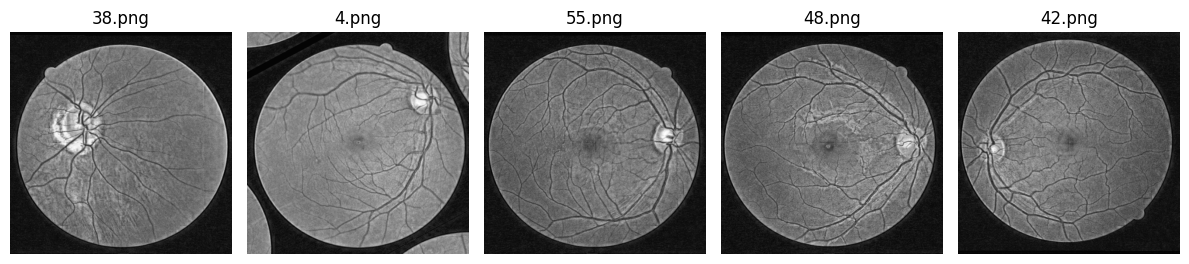

In [ ]:
# Plot 5 enhanced images from the training set
num_images = 5
random_indices = np.random.choice(X_train.shape[0], num_images, replace=False)

fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
for i, idx in enumerate(random_indices):
  axes[i].imshow(X_train[idx], cmap = 'gray')
  axes[i].set_title(f'{idx}.png')
  axes[i].axis('off')
plt.tight_layout()
plt.show()

## **Gray image blending**

### **Gray image blending with the masks for the training set**

In [ ]:
def blend_images_with_masks(gray_images, masks, alpha):
    """
    Blend gray images with binary masks using a specified alpha value.

    Args:
        gray_images (numpy.ndarray): Input gray image dataset with shape (N, H, W, 1).
        masks (numpy.ndarray): Corresponding binary mask dataset with shape (N, H, W).
        alpha (float): Blending parameter between [0, 1].

    Returns:
        numpy.ndarray: Blended image dataset with shape (N, H, W, 1).
    """
    #blended_images = ((255 - gray_images) + alpha * masks[..., None]) / (1 + alpha)
    blended_images = (gray_images + alpha * masks[..., None]) / (1 + alpha)
    return blended_images

def blend_gray_images_with_masks(X_train, Y_train, alpha_values = [0.0, 0.25, 0.5, 0.75, 1.0]):
    """
    Blend gray images with binary masks using different alpha values.

    Args:
        X_train (numpy.ndarray): Input gray image dataset with shape (N, H, W, 1).
        Y_train (numpy.ndarray): Corresponding binary mask dataset with shape (N, H, W).

    Returns:
        numpy.ndarray: Blended image dataset with shape (5N, H, W, 1).
        numpy.ndarray: Blended mask dataset with shape (5N, H, W).
    """
    # Initialize numpy arrays to store blended images and masks
    blended_images_dataset = np.zeros((len(alpha_values) * len(X_train), 512, 512, 1))
    blended_masks_dataset = np.zeros((len(alpha_values) * len(X_train), 512, 512))

    # Apply blending for each alpha value
    for i, alpha in enumerate(alpha_values):
        # Blend images with masks
        blended_images = blend_images_with_masks(X_train, Y_train, alpha)

        # Fill the blende images and masks arrays
        blended_images_dataset[i*len(X_train):(i+1)*len(X_train), :, :, :] = blended_images
        blended_masks_dataset[i*len(X_train):(i+1)*len(X_train), :, :] = Y_train

    return blended_images_dataset, blended_masks_dataset


In [ ]:
#blended_images, blended_masks = blend_gray_images_with_masks(X_train, Y_train, alpha_values = [0.0, 0.25, 0.5, 0.75, 1.0])
blended_images, blended_masks = blend_gray_images_with_masks(X_train, Y_train, alpha_values = [0.0])

In [ ]:
print(X_train.shape)
print(blended_images.shape)
print(Y_train.shape)
print(blended_masks.shape)

(80, 512, 512, 1)
(80, 512, 512, 1)
(80, 512, 512)
(80, 512, 512)


### **Plotting the result of blending**

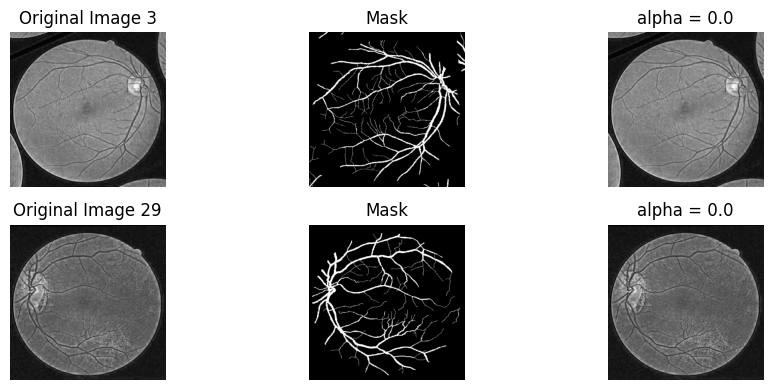

In [ ]:
alpha_values = [0.0]

# Select 5 random indices
random_indices = np.random.choice(len(X_train), 2)

# Create subplots
fig, axes = plt.subplots(2, 2 + len(alpha_values), figsize=(10, 4))

for i, idx in enumerate(random_indices):
    # Plot original image
    axes[i, 0].imshow(X_train[idx].astype(np.uint8), cmap = 'gray')
    axes[i, 0].set_title(f'Original Image {idx}')
    axes[i, 0].axis('off')

    # Plot corresponding mask
    # Masks are repeated every 80 steps
    axes[i, 1].imshow(blended_masks[idx].astype(np.uint8), cmap = 'gray')
    axes[i, 1].set_title('Mask')
    axes[i, 1].axis('off')

    for j, alpha in enumerate(alpha_values):
      # Plot blended image for alpha = 0
      axes[i, j + 2].imshow(blended_images[idx + j*len(X_train)].astype(np.uint8), cmap = 'gray')
      axes[i, j + 2].set_title(f'alpha = {alpha}')
      axes[i, j + 2].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
X_train = blended_images
Y_train = blended_masks

## **Applying image augmentation**

In [ ]:
X_train_enlarged, Y_train_enlarged = apply_custom_augmentation(X_train, Y_train, augmentation_factor = 6)

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_train_enlarged.shape)
print(Y_train_enlarged.shape)

(80, 512, 512, 1)
(80, 512, 512)
(560, 512, 512, 1)
(560, 512, 512)


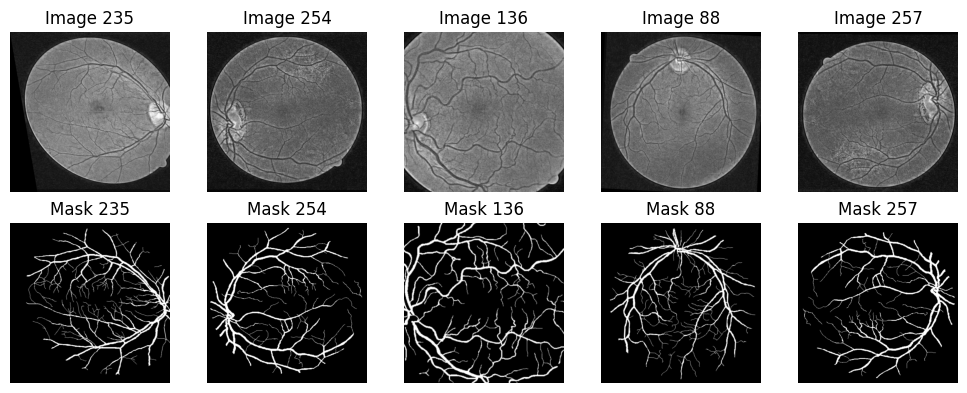

In [ ]:
# Get five random indices
random_indices = random.sample(range(len(X_train_enlarged)), 5)

# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, idx in enumerate(random_indices):
    # Plot image
    axes[0, i].imshow(X_train_enlarged[idx].astype(np.uint8), cmap='gray')
    axes[0, i].set_title(f'Image {idx}')
    axes[0, i].axis('off')

    # Plot mask
    axes[1, i].imshow(Y_train_enlarged[idx].astype(np.uint8), cmap='gray')
    axes[1, i].set_title(f'Mask {idx}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


## **Generating patches of the images**

### **Generating training patches**

In [ ]:
patch_size = 256    ########################################################################
# Generate non-overlapping patches
image_patch_train, mask_patch_train = generate_non_overlapping_patches(X_train_enlarged, Y_train_enlarged, patch_size)

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(image_patch_train.shape)
print(mask_patch_train.shape)

(80, 512, 512, 1)
(80, 512, 512)
(2240, 256, 256, 1)
(2240, 256, 256)


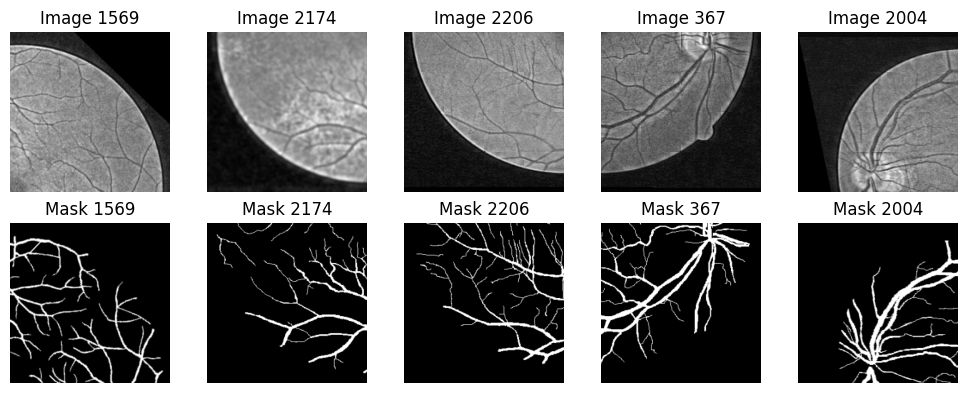

In [ ]:
# Get five random indices
random_indices = random.sample(range(len(image_patch_train)), 5)

# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, idx in enumerate(random_indices):
    # Plot image
    axes[0, i].imshow(image_patch_train[idx].astype(np.uint8), cmap='gray')
    axes[0, i].set_title(f'Image {idx}')
    axes[0, i].axis('off')

    # Plot mask
    axes[1, i].imshow(mask_patch_train[idx].astype(np.uint8), cmap='gray')
    axes[1, i].set_title(f'Mask {idx}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


## **Building the UNet**

In [ ]:
from tensorflow.keras import regularizers

def build_unet(input_shape, dropout_rate, l2_penalty):

    inputs = Input(shape = input_shape)
    #s = tf.keras.layers.Lambda(lambda x: x / 255.0)(inputs)

    # Encoder
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l2_penalty))(inputs)
    conv1 = BatchNormalization(axis=3)(conv1)
    conv1 = Dropout(dropout_rate)(conv1)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization(axis=3)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = BatchNormalization(axis=3)(conv2)
    conv2 = Dropout(dropout_rate)(conv2)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization(axis=3)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = BatchNormalization(axis=3)(conv3)
    conv3 = Dropout(dropout_rate)(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization(axis=3)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = BatchNormalization(axis=3)(conv4)
    conv4 = Dropout(dropout_rate)(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization(axis=3)(conv4)
    #drop4 = Dropout(dropout_rate)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottom
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l2_penalty))(pool4)
    conv5 = BatchNormalization(axis=3)(conv5)
    conv5 = Dropout(dropout_rate)(conv5)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = BatchNormalization(axis=3)(conv5)
    #drop5 = Dropout(dropout_rate)(conv5)

    # Decoder
    up6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    merge6 = concatenate([up6, conv4])
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = BatchNormalization(axis=3)(conv6)
    conv6 = Dropout(dropout_rate)(conv6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = BatchNormalization(axis=3)(conv6)

    up7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([up7, conv3])
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = BatchNormalization(axis=3)(conv7)
    conv7 = Dropout(dropout_rate)(conv7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = BatchNormalization(axis=3)(conv7)

    up8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([up8, conv2])
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = BatchNormalization(axis=3)(conv8)
    conv8 = Dropout(dropout_rate)(conv8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = BatchNormalization(axis=3)(conv8)

    up9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([up9, conv1])
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = BatchNormalization(axis=3)(conv9)
    conv9 = Dropout(dropout_rate)(conv9)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = BatchNormalization(axis=3)(conv9)

    # Output
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    return model


### **Adjusting the pixel values between 0 and 1**

In [ ]:
def adjustData(img, mask):
    img = img.astype('float32') / 255.0
    mask = mask /255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img, mask)

In [ ]:
image_patch_train, mask_patch_train = adjustData(image_patch_train, mask_patch_train)

In [ ]:
print('Shape of tarining patch image set is:' + str(image_patch_train.shape))
print('Shape of tarining patch mask set is:' + str(mask_patch_train.shape))
print('==========================================================================')
print('The value of the 1st pixel of the 1st image patch is:' + str(image_patch_train[0, 0, 0, 0]))
print('The value of the 1st pixel of the 1st mask patch is:' + str(mask_patch_train[0, 0, 0]))
print('==========================================================================')
print('The data type of the 1st pixel of the 1st image patch is:' + str(type(image_patch_train[0, 0, 0, 0])))
print('The data type of the 1st pixel of the 1st mask patch is:' + str(type(mask_patch_train[0, 0, 0])))

Shape of tarining patch image set is:(2240, 256, 256, 1)
Shape of tarining patch mask set is:(2240, 256, 256)
The value of the 1st pixel of the 1st image patch is:0.44928458
The value of the 1st pixel of the 1st mask patch is:0.0
The data type of the 1st pixel of the 1st image patch is:<class 'numpy.float32'>
The data type of the 1st pixel of the 1st mask patch is:<class 'numpy.float64'>


### **Building the U-Net model**

In [ ]:
input_shape = (256, 256, 1)     ########################################################
dropout_rate = 0.1
l2_penalty = 0.001
model = build_unet(input_shape, dropout_rate, l2_penalty)

### **Compiling the model**

### **Defining dice coefficient, IoU coefficient, and IoU loss**

In [ ]:
def dice_coef(y_true, y_pred, threshold=0.5):
    # Convert predicted values to binary using the threshold
    y_pred_binary = tf.cast(tf.math.greater(y_pred, threshold), dtype=tf.float32)

    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred_binary)

    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)

    return (2.0 * intersection + 1.0) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1.0)


def IoU_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection + 1.0)

def IoU_loss(y_true, y_pred):
    return -IoU_coef(y_true, y_pred)

### **Compiling the model**

In [ ]:
# Compile the model
model.compile(optimizer=Adam(lr=1e-2), loss='binary_crossentropy', metrics=['accuracy', dice_coef])
#model.compile(optimizer = Adam(lr = 1e-2), loss= IoU_loss, metrics= ['accuracy', dice_coef])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['batch_normalization[0][0

## **Training the model**

In [ ]:
# Fit the model
history = model.fit(image_patch_train, mask_patch_train, epochs = 150, batch_size = 32, validation_split = 0.1)

Epoch 1/150
63/63 [==============================] - 59s 460ms/step - loss: 0.7397 - accuracy: 0.8218 - dice_coef: 0.5161 - val_loss: 0.3918 - val_accuracy: 0.9054 - val_dice_coef: 0.1107
Epoch 2/150
63/63 [==============================] - 28s 450ms/step - loss: 0.3553 - accuracy: 0.9525 - dice_coef: 0.7461 - val_loss: 0.3327 - val_accuracy: 0.9012 - val_dice_coef: 0.0244
Epoch 3/150
63/63 [==============================] - 29s 457ms/step - loss: 0.2449 - accuracy: 0.9596 - dice_coef: 0.7679 - val_loss: 0.3249 - val_accuracy: 0.9034 - val_dice_coef: 0.0501
Epoch 4/150
63/63 [==============================] - 29s 468ms/step - loss: 0.1861 - accuracy: 0.9612 - dice_coef: 0.7729 - val_loss: 0.2258 - val_accuracy: 0.9239 - val_dice_coef: 0.3927
Epoch 5/150
63/63 [==============================] - 29s 464ms/step - loss: 0.1523 - accuracy: 0.9625 - dice_coef: 0.7812 - val_loss: 0.1877 - val_accuracy: 0.9350 - val_dice_coef: 0.5195
Epoch 6/150
63/63 [==============================] - 29s 463

In [ ]:
# Save the model to a file
model.save('/content/drive/MyDrive/Retina_Vascular_Segmentation/Data/vessel_segmentation_unet_model.h5')

## **Plotting the predicted results for the training set**

1/1 [==============================] - 0s 22ms/step


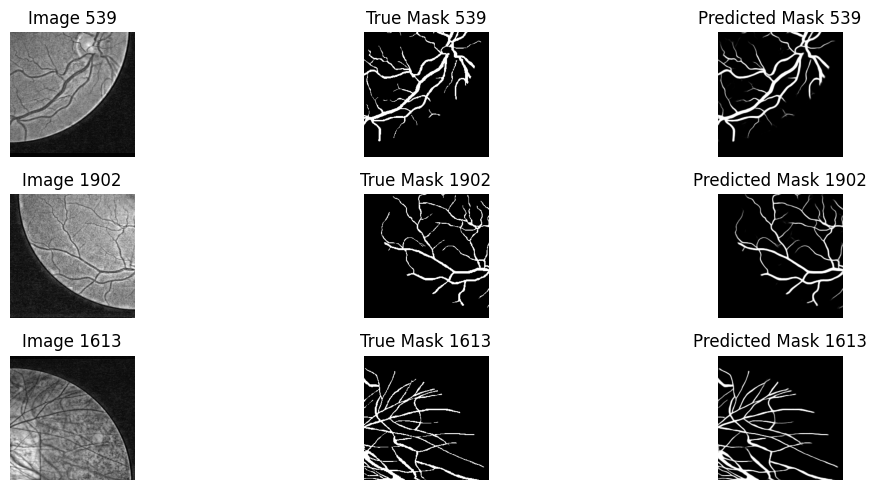

In [ ]:
# Choose three random indices
random_indices = np.random.choice(len(image_patch_train), 3, replace=False)

plt.figure(figsize=(15, 5))

for i, idx in enumerate(random_indices):

    # Load an image and its corresponding true segmented mask
    image = image_patch_train[idx, :, :, 0]
    true_mask = mask_patch_train[idx, :, :]

    # Predict the segmented mask using the trained model
    predicted_mask = model.predict(np.expand_dims(image, axis=0))[0, :, :, 0]

    # Plot the results
    plt.subplot(3, 4, 4 * i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Image {idx}")
    plt.axis("off")

    plt.subplot(3, 4, 4 * i + 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title(f"True Mask {idx}")
    plt.axis("off")

    plt.subplot(3, 4, 4 * i + 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title(f"Predicted Mask {idx}")
    plt.axis("off")

plt.tight_layout()
plt.show()


## **Preparing the test dataset**

### **Applying image preprocessing, graying, and patching on the test dataset**

In [ ]:
# Apply the image pre-processing steps on X_test
enhanced_images_test = image_preprocessor(X_test)
X_test = enhanced_images_test

# Convert RGB images to 1-channel gray images
#gray_test_images = rgb_to_gray_weighted(X_test)
blended_test_images, blended_test_masks = blend_gray_images_with_masks(X_test, Y_test, alpha_values = [0.0])

# Generate patches for the test data
image_patch_test, mask_patch_test = generate_non_overlapping_patches(blended_test_images, blended_test_masks, patch_size)

In [ ]:
# Normalize the images and their masks in the test set
#image_patch_test = image_patch_test.astype('float32') / 255.0
#mask_patch_test = mask_patch_test.astype('float32') / 255.0

image_patch_test, mask_patch_test = adjustData(image_patch_test, mask_patch_test)

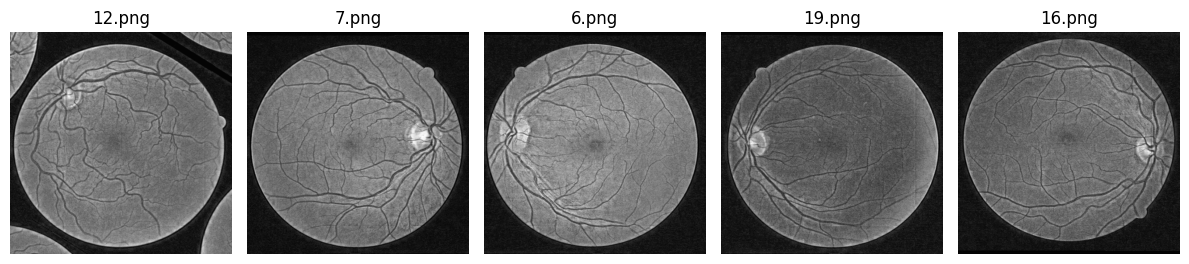

In [ ]:
num_images = 5
random_indices = np.random.choice(blended_test_images.shape[0], num_images, replace=False)

fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
for i, idx in enumerate(random_indices):
  axes[i].imshow(blended_test_images[idx], cmap = 'gray')
  axes[i].set_title(f'{idx}.png')
  axes[i].axis('off')
plt.tight_layout()
plt.show()

## **Evaluation**

In [ ]:
def calculate_metrics(model, X_test, Y_test, threshold=0.5):
    """
    Calculate various metrics for a U-Net model on a test set.

    Args:
        model (tf.keras.Model): Trained U-Net model.
        X_test (numpy.ndarray): Test dataset.
        Y_test (numpy.ndarray): Ground truth masks.
        threshold (float): Threshold for converting probabilities to binary (default is 0.5).

    Returns:
        float: Average F1 score.
        float: Average AUC score.
        float: Average accuracy.
        float: Average Dice coefficient.
    """
    num_samples = X_test.shape[0]
    f1_scores = []
    auc_scores = []
    accuracy_scores = []
    dice_coefficients = []

    for i in range(num_samples):
        # Predictions
        predictions = model.predict(np.expand_dims(X_test[i], axis=0))[0]

        # Convert predictions to binary
        binary_predictions = (predictions > threshold).astype(np.uint8)
        Y_test_binary = (Y_test[i] > 0.5).astype(np.uint8)  # Ensure ground truth is binary

        # Flatten the arrays for metrics calculation
        Y_test_flat = Y_test_binary.flatten()
        binary_predictions_flat = binary_predictions.flatten()

        # Calculate metrics
        f1 = f1_score(Y_test_flat, binary_predictions_flat)
        #auc = roc_auc_score(Y_test_flat, binary_predictions_flat)
        try:
          auc = roc_auc_score(Y_test_flat, binary_predictions_flat)
        except ValueError:
          pass
        accuracy = accuracy_score(Y_test_flat, binary_predictions_flat)

        # Dice coefficient
        intersection = np.sum(Y_test_flat * binary_predictions_flat)
        union = np.sum(Y_test_flat) + np.sum(binary_predictions_flat)
        #dice_coefficient = (2. * intersection) / (union + 1e-8)
        dice_coefficient = (2. * intersection + 1) / (union + 1)

        # Append to lists
        f1_scores.append(f1)
        auc_scores.append(auc)
        accuracy_scores.append(accuracy)
        dice_coefficients.append(dice_coefficient)

    # Calculate averages
    avg_f1 = np.mean(f1_scores)
    avg_auc = np.mean(auc_scores)
    avg_accuracy = np.mean(accuracy_scores)
    avg_dice = np.mean(dice_coefficients)

    return avg_f1, avg_auc, avg_accuracy, avg_dice


In [ ]:
avg_f1, avg_auc, avg_accuracy, avg_dice = calculate_metrics(model, image_patch_train, mask_patch_train)
print("Average Training F1 Score:", avg_f1)
print("Average Training AUC Score:", avg_auc)
print("Average Training Accuracy:", avg_accuracy)
print("Average Training Dice Coefficient:", avg_dice)

1/1 [==============================] - 0s 19ms/step
Average Training F1 Score: 0.8702835358092671
Average Training AUC Score: 0.9198792413912517
Average Training Accuracy: 0.9784248488289969
Average Training Dice Coefficient: 0.8702975457708495


In [ ]:
avg_f1, avg_auc, avg_accuracy, avg_dice = calculate_metrics(model, image_patch_test, mask_patch_test)
print("Average Test F1 Score:", avg_f1)
print("Average Test AUC Score:", avg_auc)
print("Average Test Accuracy:", avg_accuracy)
print("Average Test Dice Coefficient:", avg_dice)

1/1 [==============================] - 0s 19ms/step
Average Test F1 Score: 0.8106365096538479
Average Test AUC Score: 0.8868887202576422
Average Test Accuracy: 0.9700309753417968
Average Test Dice Coefficient: 0.8106567876234212


1/1 [==============================] - 0s 29ms/step


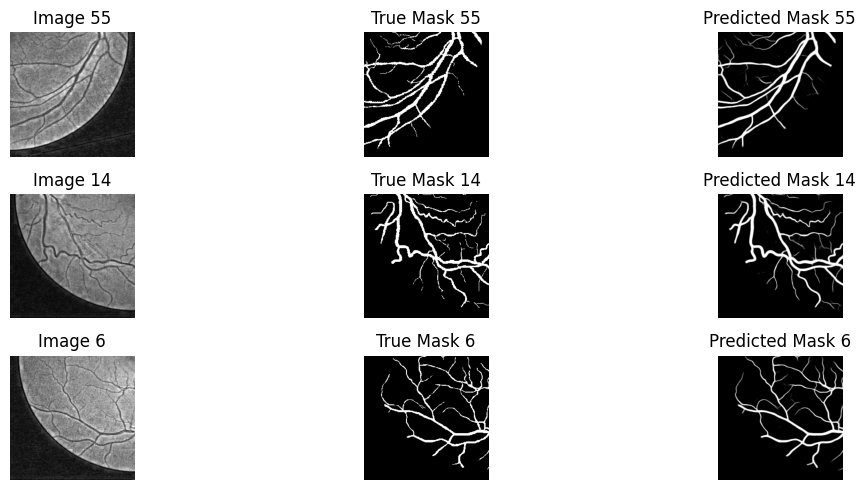

In [ ]:
# Choose three random indices
random_indices = np.random.choice(len(image_patch_test), 3, replace=False)

plt.figure(figsize=(15, 5))

for i, idx in enumerate(random_indices):

    # Load an image and its corresponding true segmented mask
    image = image_patch_test[idx, :, :, 0]
    true_mask = mask_patch_test[idx, :, :]

    # Predict the segmented mask using the trained U-Net model
    predicted_mask = model.predict(np.expand_dims(image, axis=0))[0, :, :, 0]

    # Plot the results
    plt.subplot(3, 4, 4 * i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Image {idx}")
    plt.axis("off")

    plt.subplot(3, 4, 4 * i + 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title(f"True Mask {idx}")
    plt.axis("off")

    plt.subplot(3, 4, 4 * i + 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title(f"Predicted Mask {idx}")
    plt.axis("off")

plt.tight_layout()
plt.show()


### **Predicting the masks for the whole test set**

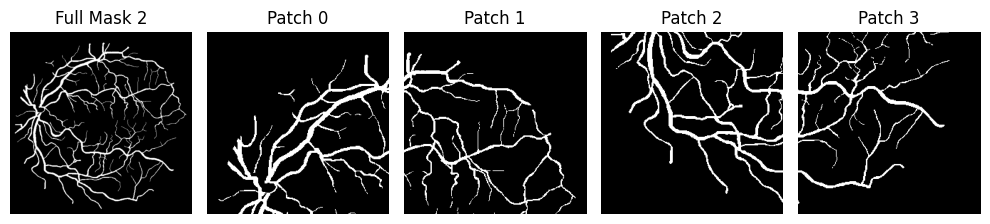

In [ ]:
index = 2
# Get the randomly chosen image and its corresponding mask
test_mask = Y_test[index]
patch_mask_0 = mask_patch_test[4*index]
patch_mask_1 = mask_patch_test[4*index + 1]
patch_mask_2 = mask_patch_test[4*index + 2]
patch_mask_3 = mask_patch_test[4*index + 3]

# Set the size of the plot
plt.figure(figsize=(10, 20))

# Plot the full mask
plt.subplot(1, 5, 1)
plt.imshow(test_mask, cmap='gray')
plt.title(f'Full Mask {index}')
plt.axis('off')

# Plot the corresponding patches
plt.subplot(1, 5, 2)
plt.imshow(patch_mask_0, cmap='gray')
plt.title("Patch 0")
plt.axis('off')

plt.subplot(1, 5, 3)
plt.imshow(patch_mask_1, cmap='gray')
plt.title("Patch 1")
plt.axis('off')

plt.subplot(1, 5, 4)
plt.imshow(patch_mask_2, cmap='gray')
plt.title("Patch 2")
plt.axis('off')

plt.subplot(1, 5, 5)
plt.imshow(patch_mask_3, cmap='gray')
plt.title("Patch 3")
plt.axis('off')

plt.tight_layout()
plt.show()

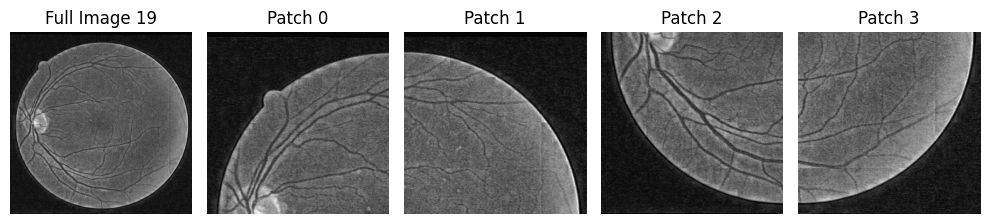

In [ ]:
index = 19

test_image = blended_test_images[index]
patch_image_0 = image_patch_test[4*index]
patch_image_1 = image_patch_test[4*index + 1]
patch_image_2 = image_patch_test[4*index + 2]
patch_image_3 = image_patch_test[4*index + 3]

# Set the size of the plot
plt.figure(figsize=(10, 20))

# Plot the full mask
plt.subplot(1, 5, 1)
plt.imshow(test_image, cmap='gray')
plt.title(f'Full Image {index}')
plt.axis('off')

# Plot the corresponding patches
plt.subplot(1, 5, 2)
plt.imshow(patch_image_0, cmap='gray')
plt.title("Patch 0")
plt.axis('off')

plt.subplot(1, 5, 3)
plt.imshow(patch_image_1, cmap='gray')
plt.title("Patch 1")
plt.axis('off')

plt.subplot(1, 5, 4)
plt.imshow(patch_image_2, cmap='gray')
plt.title("Patch 2")
plt.axis('off')

plt.subplot(1, 5, 5)
plt.imshow(patch_image_3, cmap='gray')
plt.title("Patch 3")
plt.axis('off')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 21ms/step


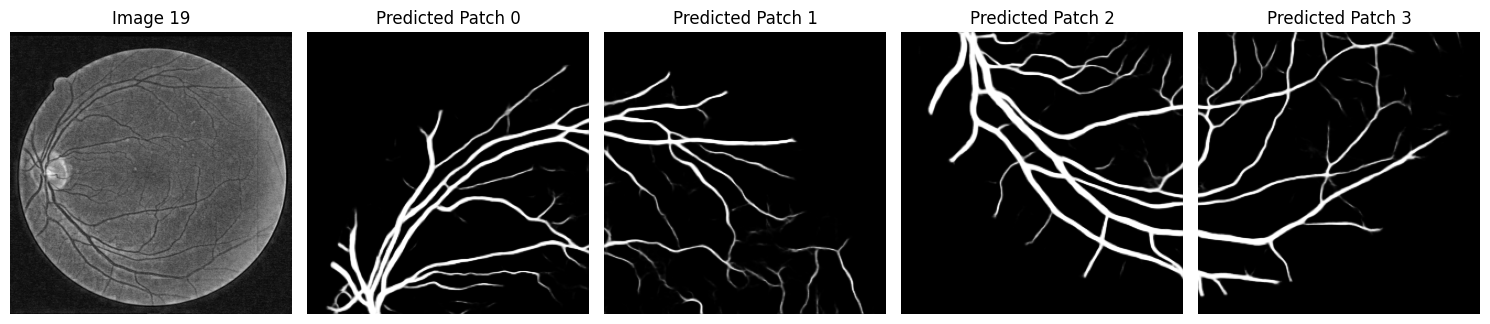

In [ ]:
index = 19

test_image = blended_test_images[index]
test_mask = blended_test_masks[index]

plt.figure(figsize=(15, 5))
# Plot the corresponding patches
plt.subplot(1, 5, 1)
plt.imshow(test_image, cmap='gray')
plt.title(f"Image {index}")
plt.axis('off')

patch_list = []

for i in range(4):

    # Load an image and its corresponding true segmented mask
    image_patch = image_patch_test[4*index + i]

    # Predict the segmented mask using the trained U-Net model
    predicted_mask_patch = model.predict(np.expand_dims(image_patch, axis=0))[0, :, :, 0]

    patch_list.append(predicted_mask_patch)

    # Plot the corresponding patches
    plt.subplot(1, 5, i + 2)
    plt.imshow(predicted_mask_patch, cmap='gray')
    plt.title(f"Predicted Patch {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()


## **Plotting the predicted mask for training images**

In [ ]:
def predicted_plotter_train(index):
  train_image = X_train[index]
  train_mask = Y_train[index]

  count = 0
  pred_image = np.zeros(train_mask.shape)

  for i in range(2):
    for j in range(2):

      # Load an image and its corresponding true segmented mask
      image_patch = image_patch_train[4*index + count]

      # Predict the segmented mask using the trained U-Net model
      predicted_mask_patch = model.predict(np.expand_dims(image_patch, axis=0))[0, :, :, 0]

      # Stitch the predicted patches
      pred_image[i*256: (i+1)*256, j*256: (j+1)*256] = predicted_mask_patch
      count = count + 1

  plt.figure(figsize=(15, 5))
  # Plot the image
  plt.subplot(1, 3, 1)
  plt.imshow(image_train[index])
  #plt.title(f"Image {index}")
  plt.axis('off')

  # Plot the true mask
  plt.subplot(1, 3, 2)
  plt.imshow(train_mask, cmap='gray')
  plt.title(f"True Mask")
  plt.axis('off')

  # Plot the predicted mask
  plt.subplot(1, 3, 3)
  plt.imshow(pred_image, cmap='gray')
  plt.title(f"Pred Mask")
  plt.axis('off')

  plt.tight_layout()
  plt.show()

1/1 [==============================] - 0s 30ms/step


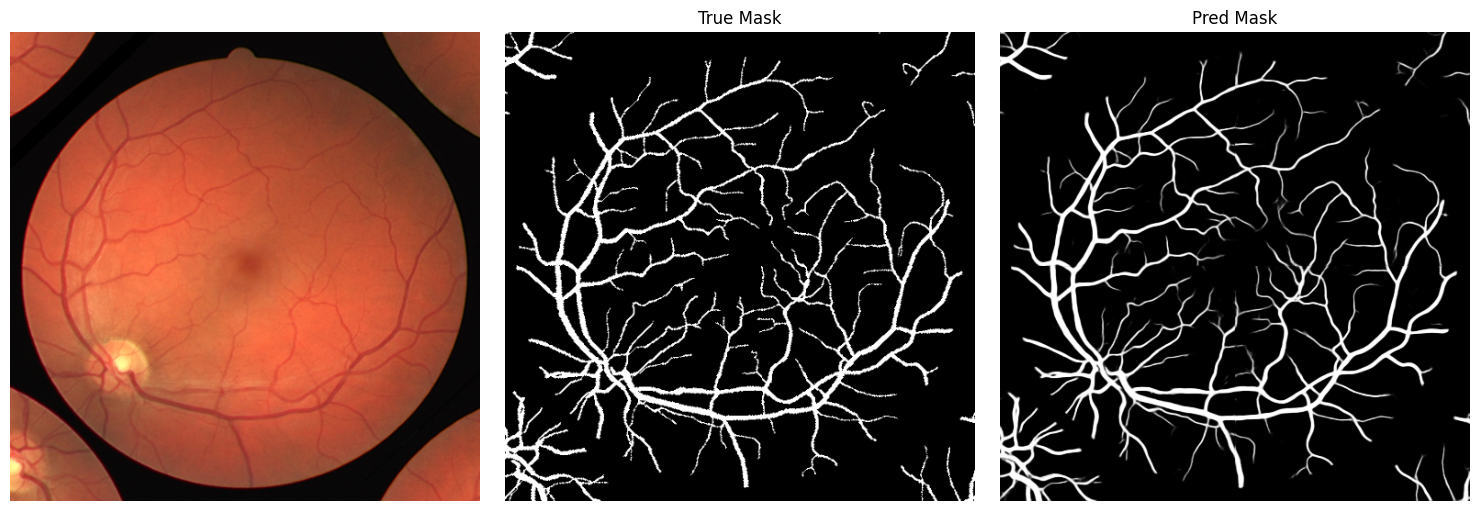

In [ ]:
predicted_plotter_train(0)

## **Plotting the predicted mask for test images**

In [ ]:
def predicted_plotter_test(index):
  test_image = blended_test_images[index]
  test_mask = blended_test_masks[index]

  count = 0
  pred_image = np.zeros(test_mask.shape)

  for i in range(2):    ##########################################################
    for j in range(2):    ##########################################################

      # Load an image and its corresponding true segmented mask
      image_patch = image_patch_test[4*index + count]

      # Predict the segmented mask using the trained U-Net model
      predicted_mask_patch = model.predict(np.expand_dims(image_patch, axis=0))[0, :, :, 0]

      # Stitch the predicted patches
      pred_image[i*256: (i+1)*256, j*256: (j+1)*256] = predicted_mask_patch
      count = count + 1

  plt.figure(figsize=(15, 5))
  # Plot the image
  plt.subplot(1, 3, 1)
  plt.imshow(image_test[index])
  #plt.title(f"Image {index}")
  plt.axis('off')

  # Plot the true mask
  plt.subplot(1, 3, 2)
  plt.imshow(test_mask, cmap='gray')
  plt.title(f"True Mask")
  plt.axis('off')

  # Plot the predicted mask
  plt.subplot(1, 3, 3)
  plt.imshow(pred_image, cmap='gray')
  plt.title(f"Pred Mask")
  plt.axis('off')

  plt.tight_layout()
  plt.show()







1/1 [==============================] - 0s 21ms/step


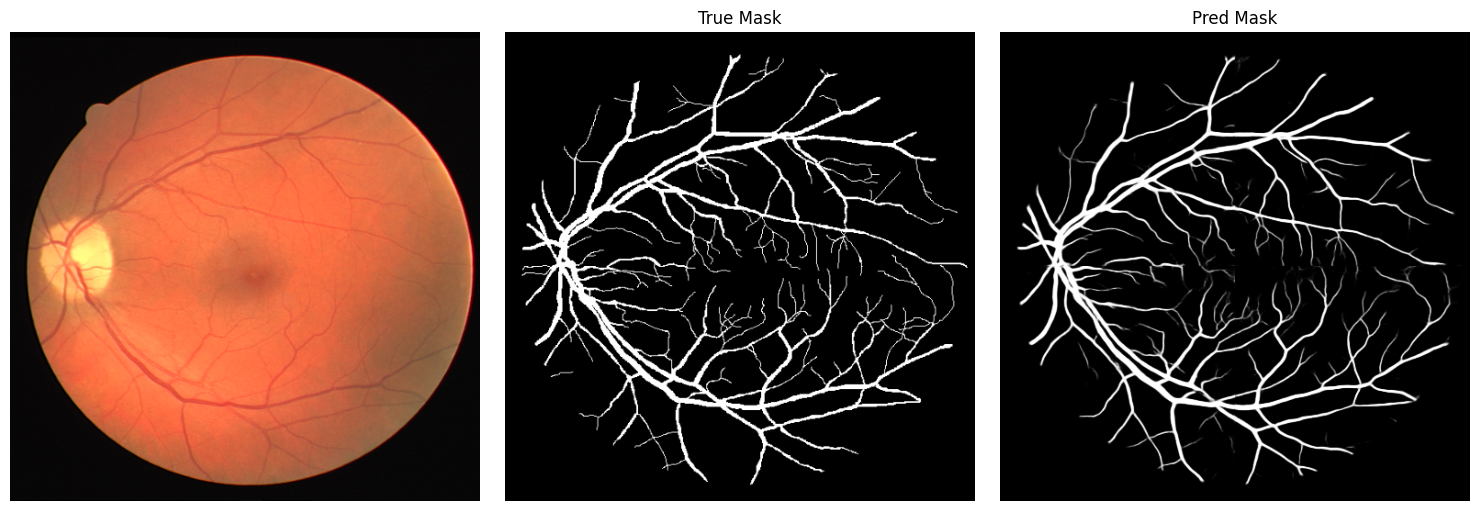

In [ ]:
predicted_plotter_test(10)